### 3) 세 번째 이미지 : 배경이 복잡한 인물 사진 

(2920, 4096, 3)


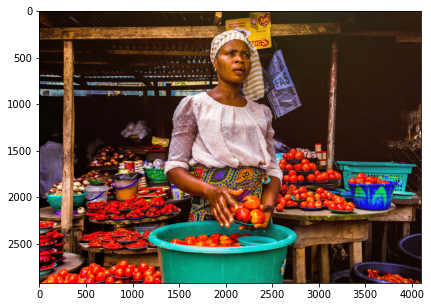

In [141]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/woman_with_background1.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [142]:
segvalues, output = model.segmentAsPascalvoc(img_path)

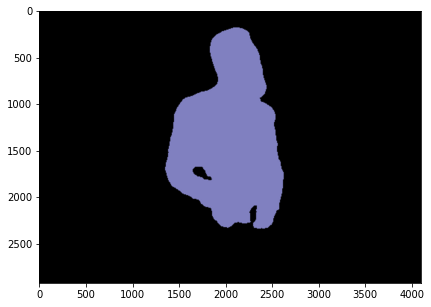

In [143]:
plt.figure(figsize=(10,5))
plt.imshow(output)
plt.show()

In [144]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [145]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [146]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] 

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [147]:
colormap[15]

array([192, 128, 128])

In [148]:
seg_color = (128,128,192)

(2920, 4096)


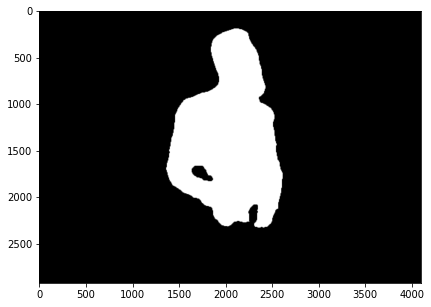

In [149]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 

plt.figure(figsize=(10,5))
plt.imshow(seg_map, cmap='gray')
plt.show()

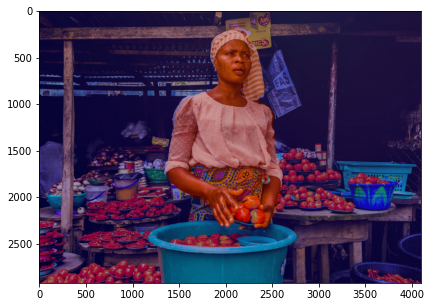

In [150]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

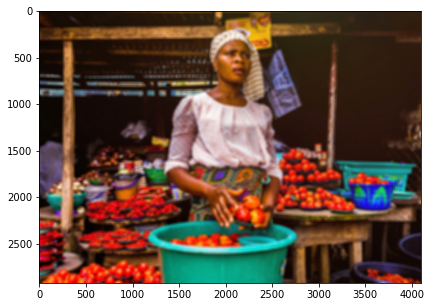

In [151]:
img_orig_blur = cv2.blur(img_orig, (35,35))
  
plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

배경이 복잡하고 배경의 요소마다 원근이 다른 두번째 사진이, 상대적으로 일정한 첫번째 사진보다 blurring kernel size를 높여야했다. 

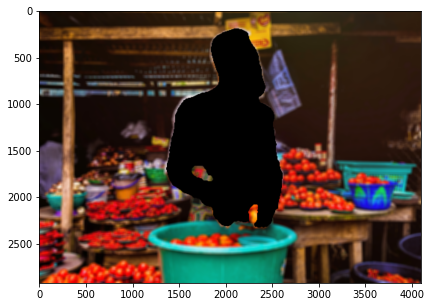

In [152]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

첫 번째 사진에서 segmentation이 깔끔하게 잘 됐던 반면, 두 번째 이미지에서는 치마 중 일부가 배경으로 인식되었다. 

In [153]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
img_woman = img_concat.copy()

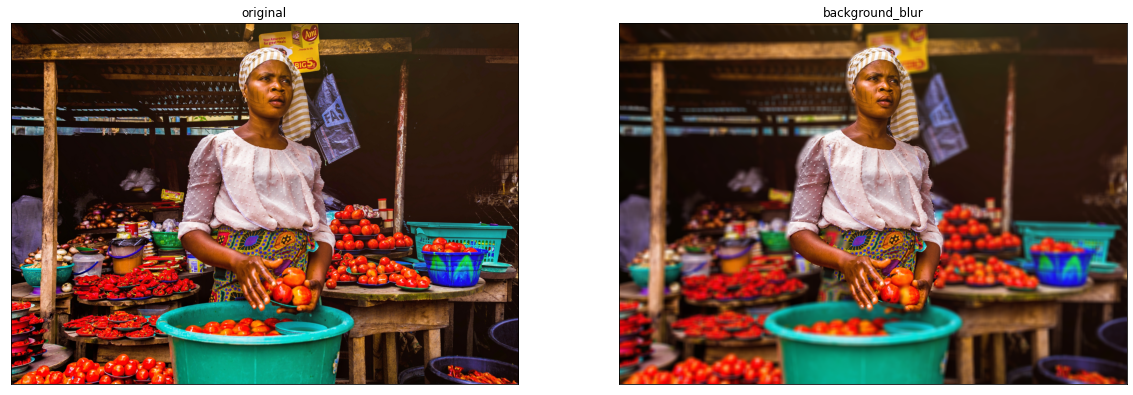

In [155]:
fig = plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('original')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)) 
plt.title('background_blur')
plt.xticks([])
plt.yticks([])
plt.show()

배경이 복잡하고 원근이 다양하다보니, 첫 번째 인물사진 보다는 윤곽선이 불분명한걸 확인할 수 있다.  

#### 이미지 배경 바꾸기 

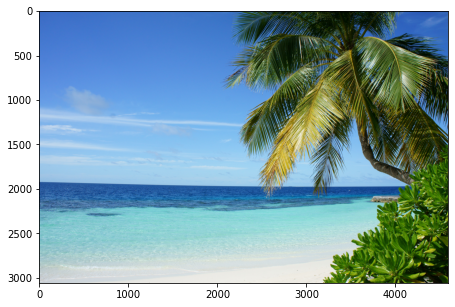

In [157]:
beach_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/beach.jpg'  
img_beach = cv2.imread(beach_path) 

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(img_beach, cv2.COLOR_BGR2RGB))
plt.show()

In [158]:
print(img_beach.shape)
print(img_orig.shape)

(3056, 4592, 3)
(2920, 4096, 3)


In [159]:
# 인물만 남기고 나머지는 0(검은색) 처리
woman_only_img_concat = np.where(img_mask_color==255, img_orig, 0)

# 이미지 resize
img_beach_resize = cv2.resize(img_beach, (4096, 2920)) # (y, x)순으로 

img_beach_resize.shape

(2920, 4096, 3)

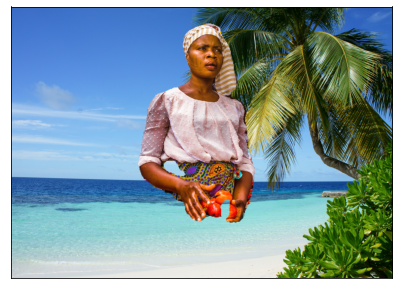

In [160]:
# 이미지 합성하기 
con = np.where(img_mask_color==255, woman_only_img_concat, img_beach_resize)

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(con, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

인물이 공중에 떠있어서 너무 부자연스럽다. 인물사진을 허리 아래로 잘라서 배경사진의 아랫부분에 붙도록 만들고 싶다.    

원본 사진과 배경 사진의 크기가 같아야하기 때문에, 좌표로 인물을 이동시키기는 어렵다.    
또한 이를 해결하기 위해 원본 사진을 잘라 처음부터 모든 과정을 다 진행하기는 번거롭다.        
   
위에서 배경이 검은 사진과, 마스크를 가져와 비율에 맞게 잘라서 사용해보자!

(1700, 2374, 3)


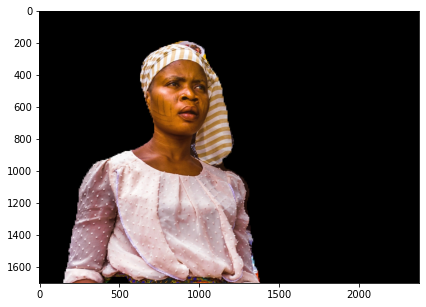

In [167]:
# 대상만 남기고 나머지는 0(검은색) 처리
woman_only_img_concat = np.where(img_mask_color==255, img_orig, 0)

# 원본 비율대로 자르기
crop_woman = woman_only_img_concat[0:1700, 861+350:3235+350]  
print(crop_woman.shape) 

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(crop_woman, cv2.COLOR_BGR2RGB))
plt.show()

인물을 가운데 놓고 잘랐더니, 합성 후에 더 부자연스러웠다.   
crop할때 350씩 추가해 인물을 왼편으로 옮겨주었다. 

(1700, 2374)


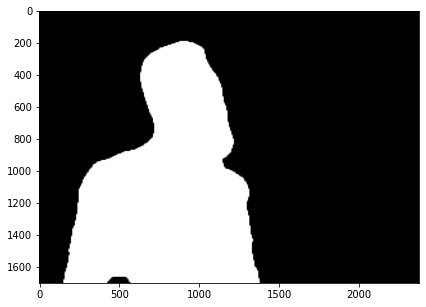

In [168]:
# 원본 비율대로 자르기 
seg_map = np.all(output==seg_color, axis=-1) 
crop_seg = seg_map[0:1700, 861+350:3235+350]
print(crop_seg.shape) 

plt.figure(figsize=(10,5))
plt.imshow(crop_seg, cmap='gray')
plt.show()

In [169]:
img_beach_resize = cv2.resize(img_beach, (2374, 1700))
img_beach_resize.shape

(1700, 2374, 3)

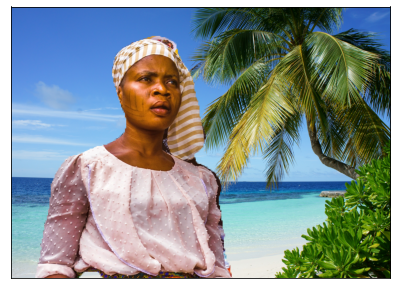

In [170]:
# 배경 합성 
img_mask = crop_seg.astype(np.uint8) * 255
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

con = np.where(img_mask_color==255, crop_woman, img_beach_resize)

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(con, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

왼쪽 어깨 부분이 원본 배경을 포함하고 있지만, 그래도 공중부양하던 사진보다 훨씬 낫다. 

## 2. 사진의 문제점 찾기
첫 번째 인물사진에는 별로 문제점이 없으니, 두 번째, 세 번째 사진의 문제점을 살펴보자. 

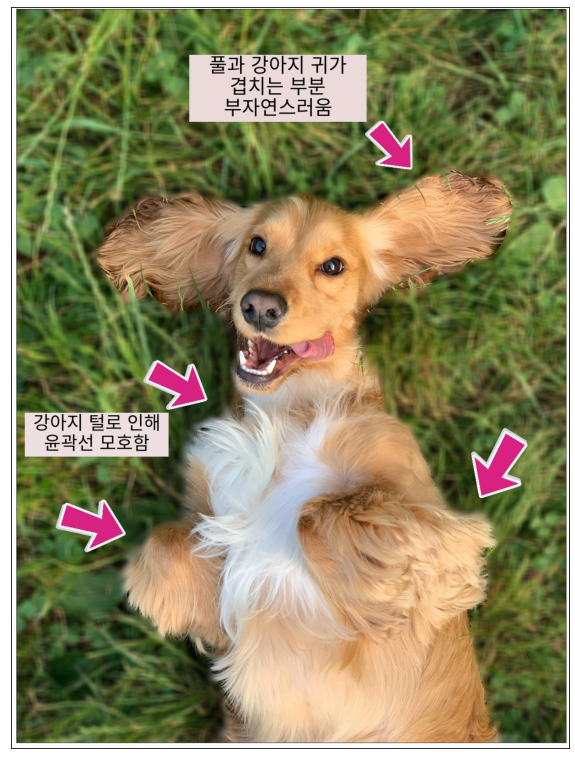

In [135]:
trouble_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog_point.jpg'  
img_trouble2 = cv2.imread(trouble_path2) 

plt.figure(figsize=(10,15))
plt.imshow(cv2.cvtColor(img_trouble2, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

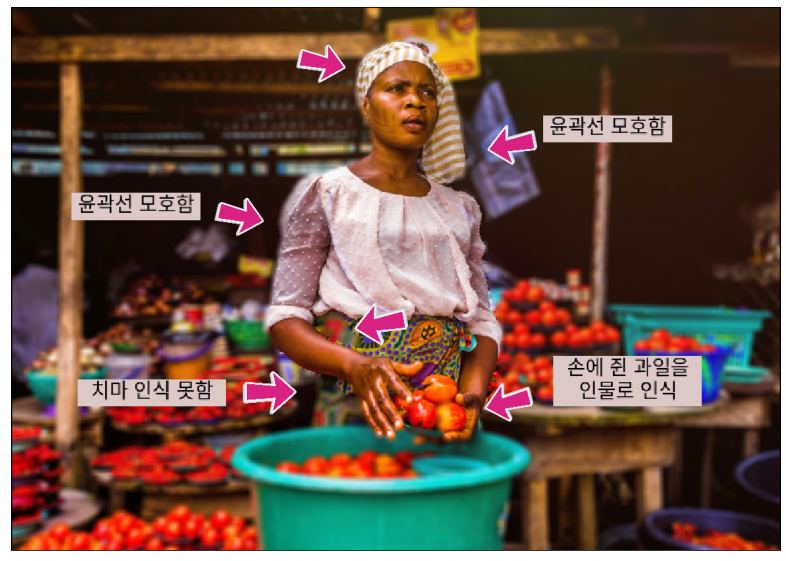

In [156]:
trouble_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/woman_point.png'  
img_trouble1 = cv2.imread(trouble_path1) 

plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(img_trouble1, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

## 3. 문제점의 원인과 해결방법 찾기 

#### 1) Semantic Segmentation
> <span style="color:blue">**Semantic Segmentation 이란?**</span>    
> 'semantic'의 사전적 정의는 '의미론적'이다.    
즉 Semantic Segmentation은 이미지 내에 있는 객체들을 픽셀 단위로 분석해, 의미있는 단위(객체의 종류)로 분류하는 작업을 나타낸다. 

Semantic Segmentation으로 만들어낸 이미지는 아래와 같은 문제점이 있다. 
- 이미지의 화질 저하(signal downsampling)

- 윤곽선의 모호함(spatial insensitivity)

#### 2) Deeplab  v3
위와 같은 문제점을 해결하기 위해, Deeplab 모델은 다음과 같은 기술을 적용했다.  
- Augmented ASPP : Deeplab v2에서는 signal downsampling 문제를 해결하기 위해 Atrous convolution을 적용했지만, 이때 rate가 커지면 커질수록 보게 되는 feature의 숫자가 작아지기 때문에 v3에는 Augmented ASPP를 적용했다. Augmented ASPP는 마지막 feature map에 Global Average Pooling(GAP)을 붙인 feature를 하나 더 사용해, 이전의 3x3 Atrous Conv와 합친 다음 1x1 Conv를 거쳐 최종 결과물을 만들어내는 방식이다. 
      
      
- Conditional Random Field : spatial insensitivity 문제를 해결하기 위한 후처리로, '사람'이라는 정보의 pixel이 있다면 주위 pixel이 '사람'일 가능성이 높은 것을 이용한 방법이다. 그러나 Deeplap v3 부터는 Augmented ASPP를 사용하면서 CRF와 같은 후처리 없이도 좋은 성능을 내기 시작해 더이상 사용하지 않게 되었다.       
     
     

    

### 위의 이미지들은 Deeplab v3 모델을 적용했음에도 몇 가지 문제가 생겼다. 어떻게 해결할 수 있을까?  

#### 1) 고화질 이미지를 사용하면 어떨까?   
위의 세 가지 이미지 중에 배경이 일정하고 원근이 적을수록, 조금 더 깔끔하게 segmentation이 되었다. 그렇다면 배경이나 인물이 선명한 이미지라면 조금 더 segmentation을 잘 할 수 있지 않을까?   
- [이 논문](https://arxiv.org/abs/2111.14482)에서는 오히려 4K, 6K의 초고해상도 이미지는 계산에 있어서 추가적인 고려사항이 필요하다고 말하고 있다 . down-sampling, patch cropping, cascade model으로는 일반적인 ultra high-resolution image segmentation에 나타나는 정확도와 손실 간의 균형 문제를 해결할 수 없기 때문이다. 이를 보아, 오히려 이미지의 해상도가 일정 수준 이상으로 높아진다면 segmentation하기 어려운 것 같다.   


#### 2) blur 방식을 바꿔보자!
위에서는 cv2.blur를 통해 5x5 범위 픽셀의 평균 구하는 평균 블러링(Averaging Blurring) 방식을 사용했다. 다른 방식의 blur를 사용한다면 어떨까?      
- 가우시안 블러링(Gaussian Blurring) : 평균 블러링과 달리, 가우시안 블러링은 중심에 있는 픽셀에 높은 가중치를 부여한다. 때문에 평균 블러링에 비해 블러링 후에도 윤곽선이 선명하다.       
   
- 미디안 블러링(Median Blurring) : 관심 픽셀 주변으로 지정한 만큼의 픽셀을 크기순으로 정렬한 후 중간값을 뽑아서 사용한다. 무작위 노이즈를 제거하는데 효과적이지만, 윤곽선이 사라지게된다.   
   
- Bilateral Filtering : 윤곽은 보존하면서 노이즈를 제거할 수 있는 방법이다.    

그 외에도 다양한 블러링 방법이 있다..   

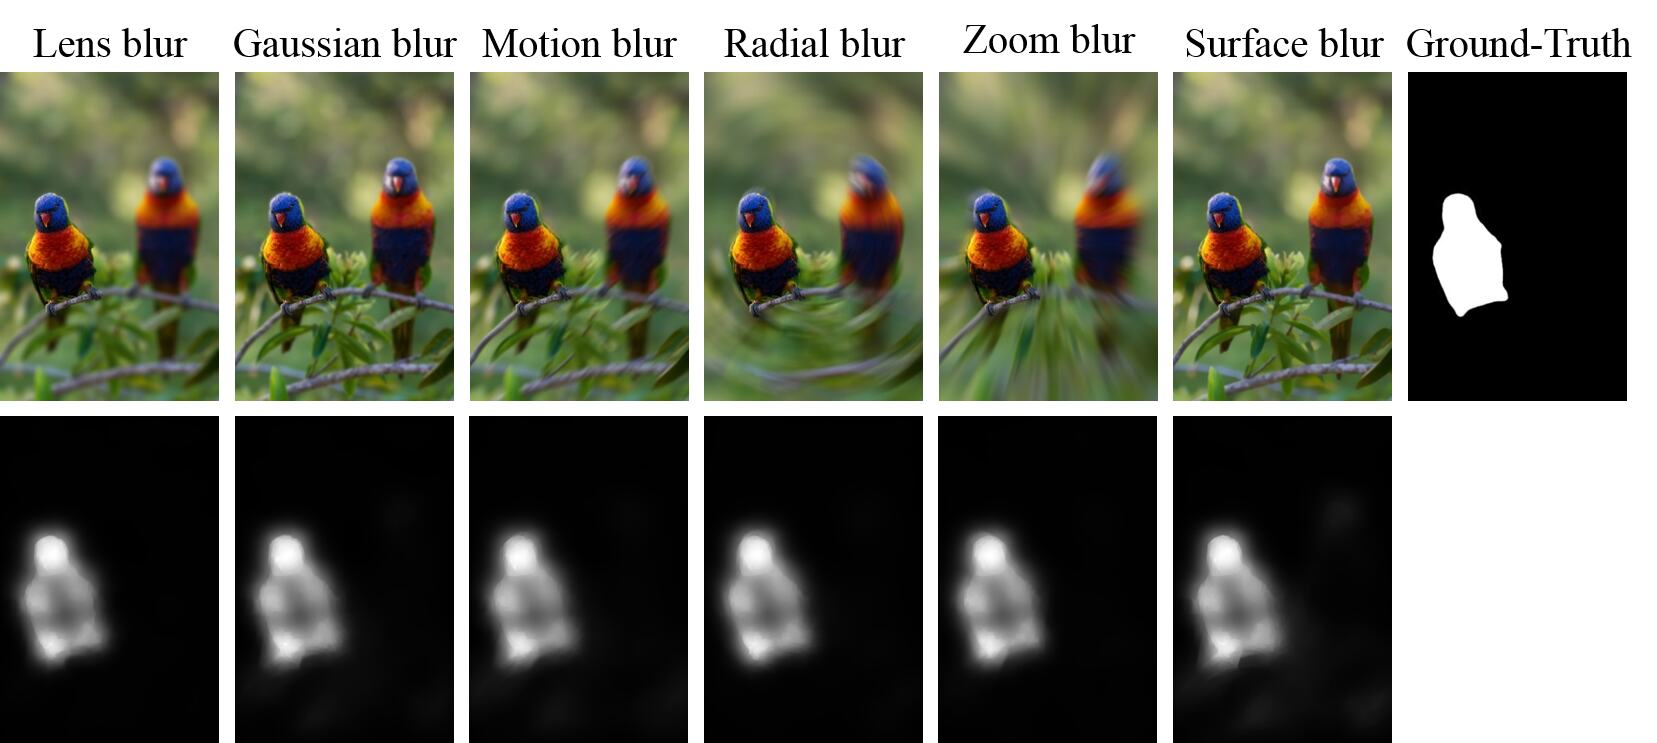


#### 3) 모델을 바꾼다.    
- [이 논문](https://www.tandfonline.com/doi/full/10.1080/09540091.2022.2082384)에서는 심층 신경망(DNN)을 기반으로한 hierarchical feature fusion image semantic segmentation을 제안한다. 이 방식은 특칭 추출(feature extraction) 과정에서 이전 단계의 특징들과 이미지 상황 정보(image contextual information)를 결합해서, 각 단계의 최종 결과(output)에서 보다 더 자세한 특징들을 점차적으로 추출할 수 있도록한다.
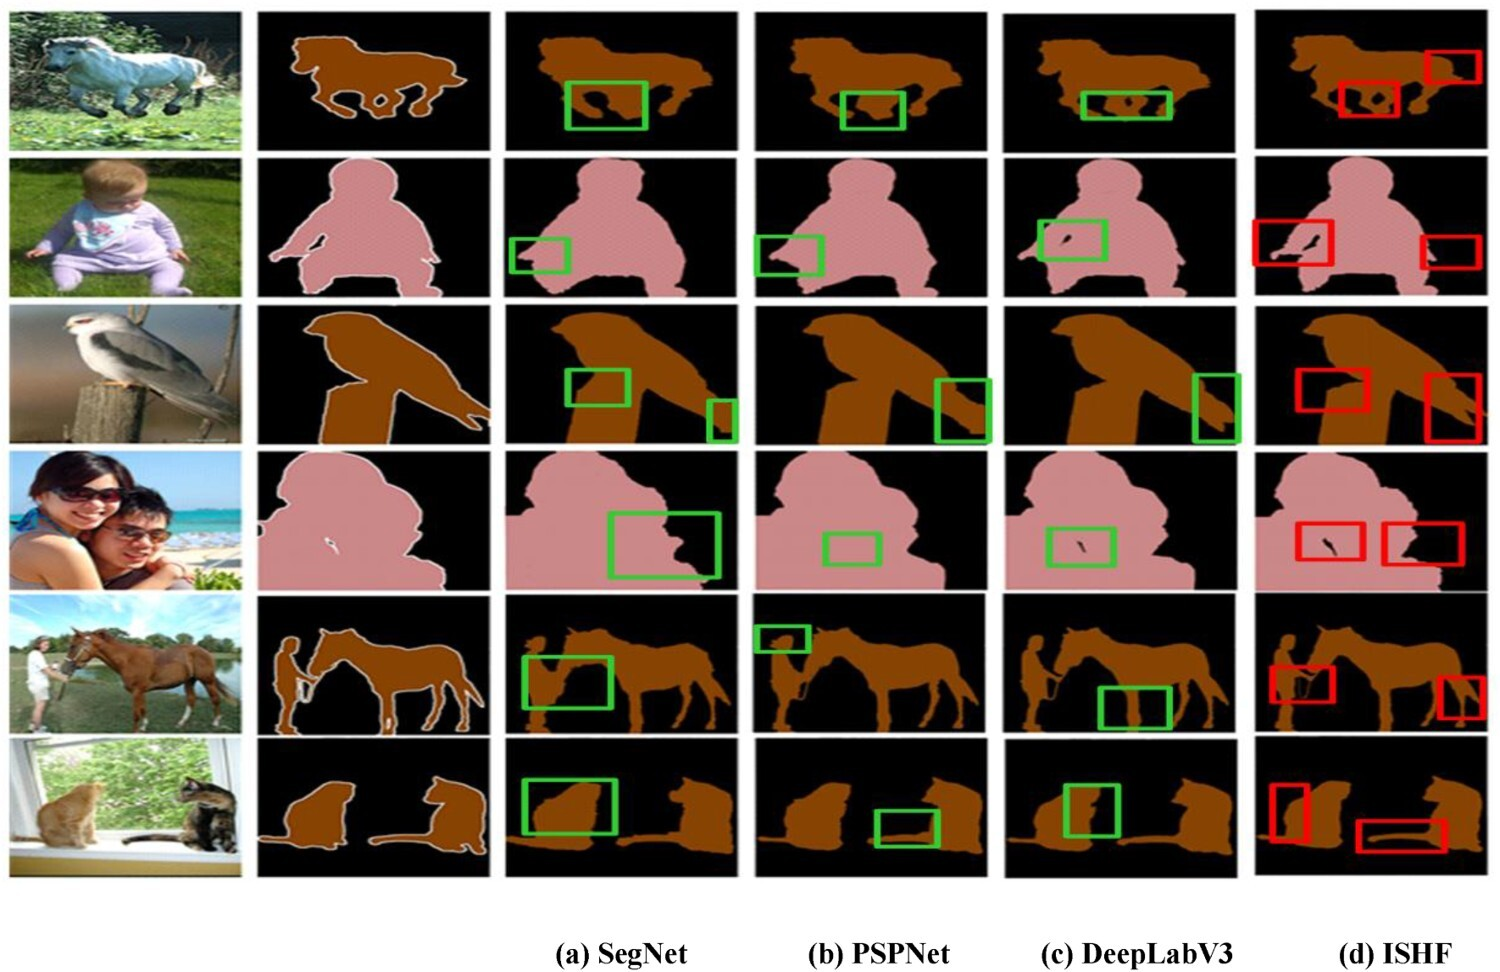        
    
- U-Net : U-Net은 Fully Convolution Network(FCN)를 기반으로 하여 구축되었으며, 적은 데이터를 가지고도 더욱 정확한 Segmentaion을 내기 위해 FCN 구조를 수정한 모델이다. 또한 U-Net은 적은 데이터로 충분한 학습을 하기 위해 Data Augmentation을 사용한다. Augmentation으로 데이터 양을 부풀림으로써 모델의 성능을 향상시킬 수 있다.    
    
- U-Net++ : U-Net과 달리 UNet++는 re-designed skip pathway를 설계했다. 이는 encoder와 decoder feature map 사이에 semantic gap을 줄여 optimizer가 더 쉽고 빠르게 학습이 된다는 것이다. 또한 U-Net에서도 Skip-Connection을 해주는 부분이 있었지만, U-Net++에서는 DenseNet의 아이디어를 차용하여 Encoder(수축 경로)와 Decoder(확장 경로)사이의 Semantic(의미적) Gap을 연결시켜 준다.


#### 4) 기타
- 모노폴로지(morphology) 연산 : 이미지에서 마스크를 추출할 때, 모노폴로지 연산을 이용한다면 윤곽을 조금 더 깔끔하게 딸 수 있을 것 같다.    
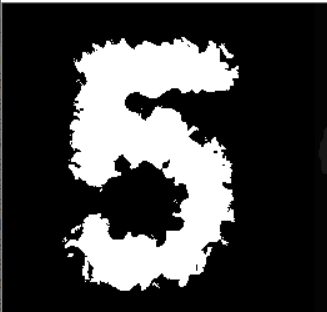 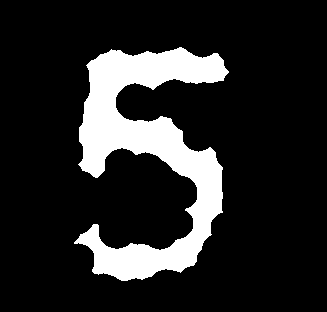        
     
- 테두리 외삽법(Border Extrapolation) : 테두리 외삽법은 평균 블러링(Averaging Blurring)에서 컨벌루션을 적용할 때, 이미지 가장자리 부분의 처리 방식을 의미한다. cv2.blur(src, ksize, anchor, borderType)에서 테두리 외삽법(borderType) 옵션을 변경한다면 윤곽을 더 깔끔하게 딸 수 있을 것 같다. 
 


Ref.     
https://webnautes.tistory.com/1255 blurring  
https://89douner.tistory.com/113  segmentation  
https://jjeong-ee.tistory.com/8  segmentation     
https://kangbk0120.github.io/articles/2022-02/deeplab-series Deeplab
https://kuklife.tistory.com/119 Unet    
https://blog.promedius.ai/unet-unet3/ UNet++와 U-Net3+       
https://wsshin.tistory.com/2 UNet++   
https://stackoverflow.com/questions/59850410/how-to-smooth-and-make-thinner-these-very-rough-images-using-opencv morphology
https://blog.naver.com/9409290274/221549688872 morphology    
https://076923.github.io/posts/Python-opencv-13/ 테두리 외삽법 



## 회고

**헤맨 부분**
- cv2.blur(img_orig, (13,13))으로 했더니 배경에 블러가 적용되지 않았다. 커널 사이즈를 (1,1)까지 줄여도 아무 변화가 없었고, (50,50)으로 늘리니 커널이 죽었다. 해당 이미지에는 (30,30)이 적당했다. 
- seg_map = np.all 부분에서 강아지 부분도 까맣게 출력되었다. label_names 에서 dogs를 찾아 colormap을 12번으로 바꿔줘야하고, 그에 따라 seg_color를 역순으로 수정해줘얀다. 사진을 바꿔도 그대로길래 노드를 다시 훑어보고 나서 깨달았다. 
- 크로마키처럼 배경을 바꾸는 부분에서 스티커 사진 코드를 그대로 가져다 써서 오래걸렸다. 퍼실님께 여쭤본 결과 스티커 코드에서는 사람의 크기에 따라 스티커 사이즈를 조절하는 부분이 있는데, 이번에는 그게 필요없는데도 resize한 후에 계속 사이즈를 바꾸는 코드를 그대로 넣다보니 에러가 난 것이었다. 
- github 최대 업로드 용량이 25mb로 알고있는데, 주피터파일이라 그런지 15mb도 업로드 후 열려하니 Unable to render rich display 에러가 난다. 
- 내가 원하는 분야의 SOTA에 오른 모델이라 하더라도, 당장 내 task에 필요한지 알기 어렵다. 논문을 읽는데 시간이 오래 걸렸다. 

**문제를 해결하기 위한 시도와 원인 추론**
- 이미지에 새로운 배경을 합성하는 과정에서 np.where를 쓰는 코드와 copyto로 사이즈 다른 이미지 바로 합치는 코드 모두 적용해보았다. 
- 세 번째 사진에 새로운 배경을 합성 할 때 허리 아랫부분이 부자연스러워서 이미지를 잘랐더니, 처음엔 합성한 사진에서 윤곽이 이상하게 따졌다. 마스크는 그대로인데 배경을 제거한 사진만 crop 하다보니 두 이미지의 위치가 일치하지 않아서 그런 것 같다.  

**새롭게 알게된 부분**
- 배경을 합성하려면 이미지 2개를 같은 사이즈로 만들어줘야한다. 
- img = cv2.resize(img, (w,h)) 이미지 사이즈 바꾸는 코드
- plt.show() 전에 plt.xticks([]), plt.yticks([])를 넣으면, 눈금이 사라져 이미지를 더 깔끔하게 볼 수 있다. 
- [여기](https://headbreakz.tistory.com/entry/code-%EC%9D%B4%EB%AF%B8%EC%A7%80%EC%97%90%EC%84%9C-%ED%94%BD%EC%85%80-%ED%88%AC%EB%AA%85%ED%99%94-%ED%95%98%EA%B8%B0)를 참조해 배경을 투명하게 한다면 인물을 스티커처럼 새로운 배경에 합성하기 더 편할 것 같다.  


**아직도 모르는 부분**
- 이해하기 어려운 코드들이 많았다.
- 대상의 일부를 잘라서 합성할때 어떻게하면 더 쉽게 crop할 수 있을까?
- 마지막 문제 해결하기 부분은 대부분 찾은 내용을 바탕으로 추론한 것이기 때문에, 실제로 적용했을때 생각했던 결과가 나올지 모르겠다. 
- 다양한 논문을 읽어보았는데, 관련 배경 지식이 부족하다보니 해당 논문이 어느정도 신빙성이 있는건지 모르겠고, 수많은 논문 중에 적합한 논문을 찾기도 어려웠다.  
